 <h1 style="text-align:center; font-style:italic;">Введение</h1>




<div class="alert alert-info" role="alert">
<center><img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Booking.com_logo2.png" style="width:200px;height:40px;">
    

### *Какой кейс решаем ?*

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.
    
<center>
    <b>Описание данных</b>
    
    
<table >
   <tr>
    <th>Признак</th>
    <th>Описание</th>
  </tr>
  
   <tr>
    <td>hotel_address</td>
    <td>адрес отеля</td>
  </tr>
    
   <tr>
    <td>additional_number_of_scoring</td>
    <td>количество оценок без отзывов</td>
  </tr>
    
  <tr>
    <td>review_date</td>
    <td>дата отзыва</td>
  </tr>
    
  <tr>
    <td>average_score</td>
    <td>средний балл отеля</td>
  </tr>
    
   <tr>
    <td>hotel_name</td>
    <td>название</td>
  </tr>
    
   <tr>
    <td>reviewer_nationality</td>
    <td>гражданство рецензента</td>
  </tr>
    
   <tr>
    <td>negative_review </td>
    <td>негативный отзыв</td>
  </tr>
   
   <tr>
    <td>review_total_negative_word_counts </td>
    <td>число слов в негативном отзыве</td>
  </tr>  
    
   <tr>
    <td>total_number_of_reviews </td>
    <td>общее число отзывов на странице отеля</td>
  </tr>  
    
   <tr>
    <td>positive_review</td>
    <td>позитивный отзыв</td>
  </tr>
    
   <tr>
    <td>review_total_positive_word_counts</td>
    <td>число слов в позитивном отзыве</td>
  </tr>
    
  <tr>
    <td>total_number_of_reviews_reviewer_has_given</td>
    <td>общее число отзывов рецензента на площадке</td>
  </tr>
    
   <tr>
    <td>reviewer_score</td>
    <td>оценка данная рецензентом отелю</td>
  </tr>
    
   <tr>
    <td>tags</td>
    <td>теги </td>
  </tr>
    
   <tr>
    <td>days_since_review</td>
    <td>дней с момента публикации отзыва</td>
  </tr>
    
   <tr>
    <td>lat</td>
    <td>координата по широте</td>
       
   <tr>
    <td>lng</td>
    <td>координата по долготе</td>
  </tr>
    
</table>
    
</div>

In [24]:
# Стандартные библиотеки для работы с таблицами и вычислениями.
import numpy as np
import pandas as pd

# Инструменты визуализации.
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотека для кодировки признаков и счетчик хешируемых объектов.
import category_encoders as ce
from collections import Counter

# Метрики и ножницы для рботы с выборками.
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, chi2

# Модели.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import lightgbm as lgb

# Делаем визуальную настройку графиков
sns.set_palette("Set2")
sns.set_theme(style="dark")

In [25]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [26]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## 1. Обзор и очистка данных

In [27]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

# Убедитесь, что kaggle.json уже лежит в ~/.kaggle/

api = KaggleApi()
api.authenticate()

# Скачиваем датасет соревнования
api.competition_download_files('sf-booking', path='.')

# Разархивируем
with zipfile.ZipFile('sf-booking.zip', 'r') as zip_ref:
    zip_ref.extractall('.')


In [28]:
# Подгрузим наши данные из соревнования

df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [30]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [31]:
# Находим дубликаты и удаляем их
all_columns = list(df_train.columns)
mask_dupl = df_train.duplicated(subset=all_columns)
data_duplicates = df_train[mask_dupl]
print(f'Количество найденных дубликатов: {data_duplicates.shape[0]}')
df_train.drop_duplicates(inplace=True,ignore_index=True)

Количество найденных дубликатов: 307


In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [33]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [34]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [35]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [36]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока что заполняем нулями

data = pd.concat([df_test, df_train], sort=False).reset_index(drop=True) # объединяем

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [38]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


In [39]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

In [40]:
data.describe(include='object')

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515431,515431,515431,515431,515431,515431,515431,515431
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2584,4789,245165,127816,35924,5101,2584


## 2. Обработка данных

### 2.1. Разбор адреса и гражданства

In [41]:
# Создадим признак - страна отеля
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])

# Для Великобритании
data.loc[data['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'

# Посмотрим, отели каких стран у нас представлены.
data['hotel_country'].value_counts()

hotel_country
United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: count, dtype: int64

In [42]:
# Создадим признак - город отеля
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

# Посмортим на города.
data['hotel_city'].value_counts()

hotel_city
London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: count, dtype: int64

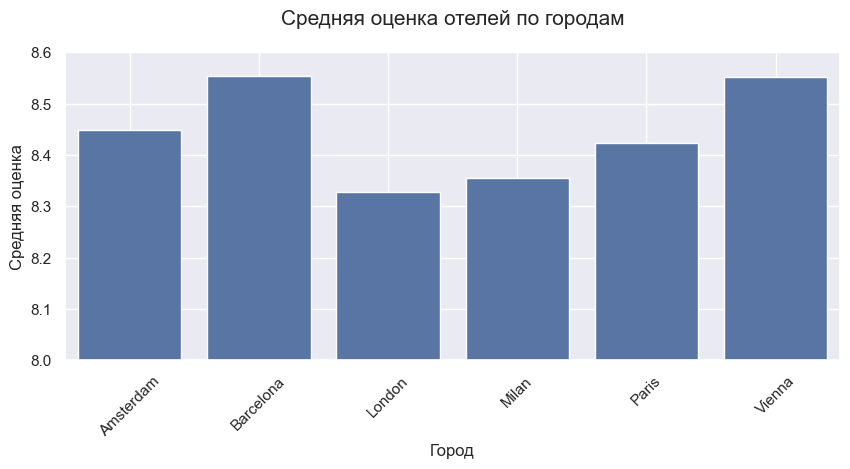

In [43]:
# Cоздадим сводную таблицу для дальнейшей визуализации.
cities_pt = pd.pivot_table(data=data[data['sample']==1], index='hotel_city', values='reviewer_score', aggfunc=['mean'])

figure, ax = plt.subplots(figsize=(10,4))
ax.set_ylim(8, 8.6);
ax.tick_params(axis='x', rotation=45)
sns.barplot(x=cities_pt.index, y=cities_pt[('mean', 'reviewer_score')]);
ax.set_xlabel('Город')
ax.set_ylabel('Средняя оценка')
ax.grid()
plt.title('Средняя оценка отелей по городам', fontsize=15, pad=20);

- Наибольшая средняя оценка отелей наблюдается в Барселоне и Вене. В Лондоне - наименьшая, но и отзывов о лондонских отелях у нас больше всего.

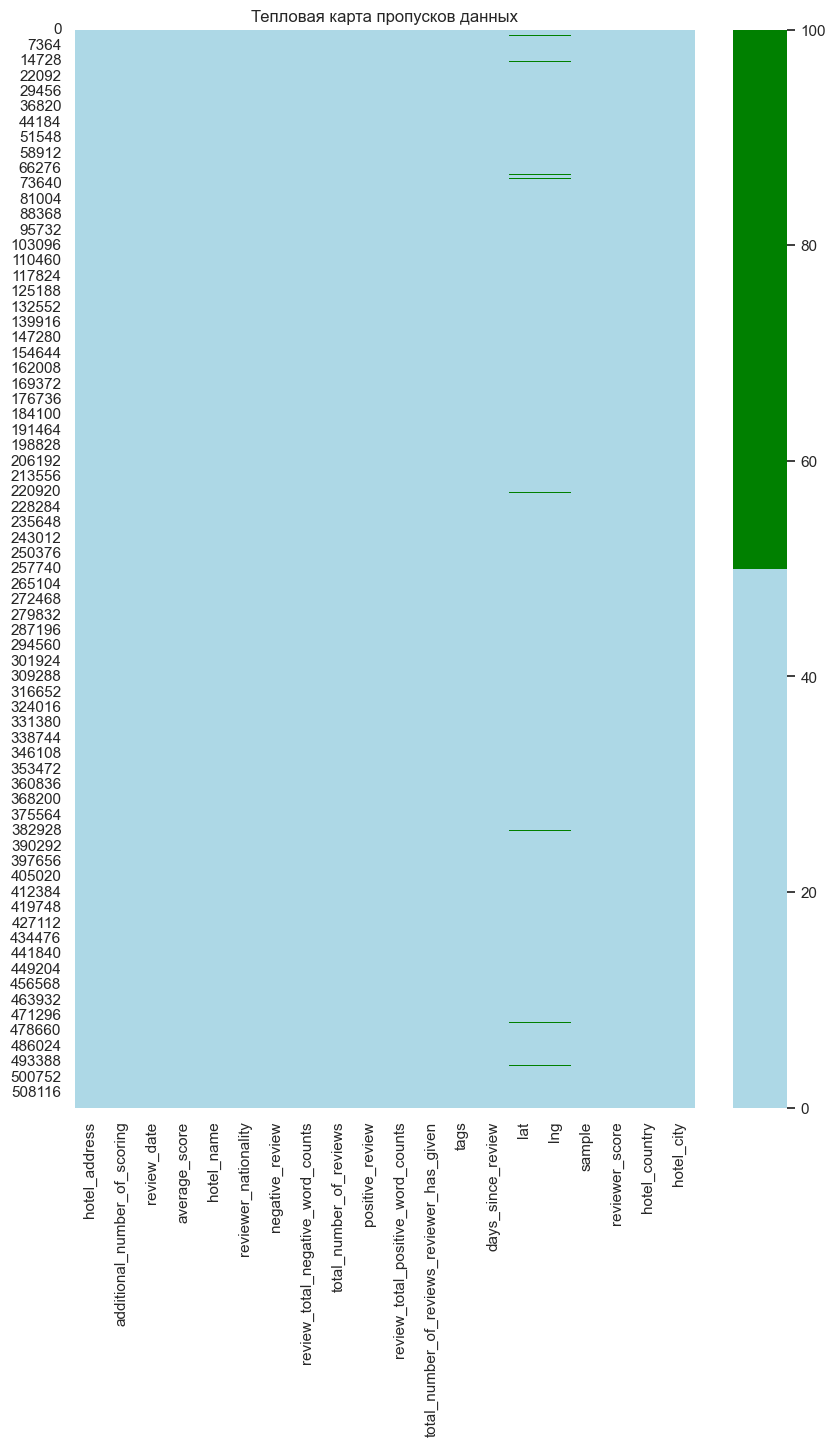

In [44]:
# Проверим датасет на наличие пропусков:
colors = ['lightblue', 'green']
fig = plt.figure(figsize=(10, 14))
cols = data.columns
ax = sns.heatmap(
    data[cols].isnull()*100,
    cmap=sns.color_palette(colors),
)
ax.set_title("Тепловая карта пропусков данных");

Пропуски в нашем датасете притствуют только в координатах *lat* и *lng*.

In [45]:
# Посмотрим в какиx городах есть пропуски
data.loc[data['lat'].isnull()]['hotel_city'].value_counts()

hotel_city
Vienna       2679
Paris         382
Barcelona     207
Name: count, dtype: int64

Так как библиотека *geopy* рабоает на Kaggle не совсем корректно, то я нашел координаты городов в пропусками на локальной машине. Поскольку *geopy* не смог идентифицировать все адреса из датасета, то чтобы не осталось пропусков, заполним их координатами центра текущего города.

In [46]:
# Зададим словарь с координатами

city_coords = {
    'Vienna':      (48.210033, 16.363449),
    'Paris':       (48.864716, 2.349014),
    'Barcelona':   (41.38879, 2.15899)
}

In [47]:
# Функция для заполнения пропусков
def fill_coords(row):
    if np.isnan(row['lat']) or np.isnan(row['lng']):
        coords = city_coords.get(row['hotel_city'])
        if coords:
            if np.isnan(row['lat']):
                row['lat'] = coords[0]
            if np.isnan(row['lng']):
                row['lng'] = coords[1]
    return row

# Применяем функцию к DataFrame
data = data.apply(fill_coords, axis=1)

 ### Гражданство ***reviewer_nationality***

In [48]:
data['reviewer_nationality'].value_counts()

reviewer_nationality
United Kingdom               245165
United States of America      35390
Australia                     21663
Ireland                       14820
United Arab Emirates          10230
                              ...  
Comoros                           1
Anguilla                          1
Tuvalu                            1
Cape Verde                        1
Palau                             1
Name: count, Length: 227, dtype: int64

In [49]:
# Создаем признак - является ли посетитель отеля гражданином страны, в которой расположен отель
data['is_citizen']=data.apply(lambda x: 1 if x['reviewer_nationality'].strip()==x['hotel_country'] else 0, axis=1)

# Разделим гражданство на категории
def nationality(args):
    if 'United Kingdom' in args:
        return 'Br'
    if 'United States of America' in args:
        return 'Am'
    else:
        return 'other'

data['nationality']=data['reviewer_nationality'].apply(nationality)

In [50]:
# Закодируем hotel_city и nationality
data = pd.get_dummies(data, columns=['hotel_city','nationality'])
# Удалим лишние признаки
data.drop([ 'nationality_other','reviewer_nationality', 'hotel_country','hotel_address'], axis=1, inplace=True)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   review_date                                 515431 non-null  object 
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

### 2.2. Разбор даты

In [52]:
# Сперва изменим тип представленных в столбце данных.
data['review_date'] = pd.to_datetime(data['review_date'])

In [53]:
# Разделим даты на кварталы
data['review_quarter'] = data['review_date'].dt.quarter

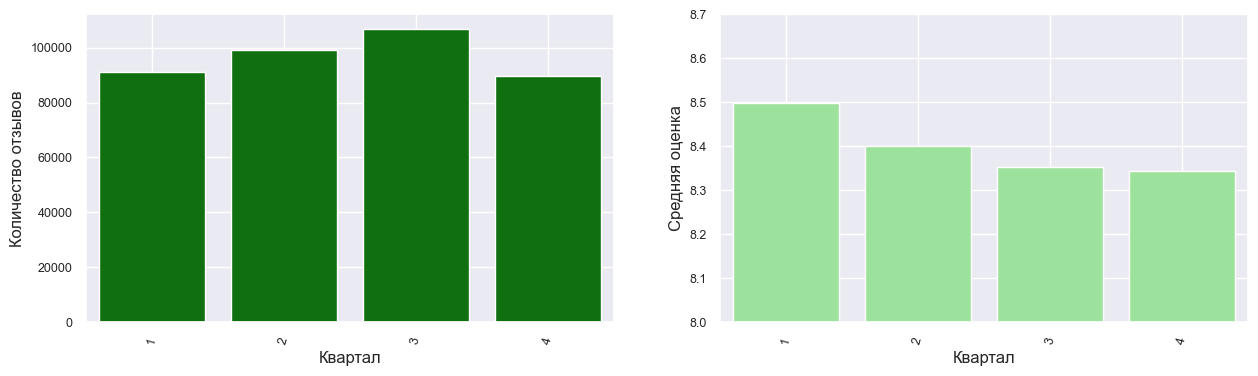

In [54]:
# Визуализируем зависимости количества отзывов и средних оценок от сезона.
quarter = data[data['sample']==1].pivot_table(values='reviewer_score', index='review_quarter', aggfunc=['mean','count'])

fig,axes = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x=quarter.index, y=quarter[('count', 'reviewer_score')], ax=axes[0], color='green')
axes[0].set_ylabel('Количество отзывов', fontsize = 12)
axes[0].tick_params(axis='x', rotation=75)
axes[0].set_xlabel('Квартал',  fontsize = 12)
axes[0].tick_params(axis='both', which='major', labelsize=9)
axes[0].grid();

sns.barplot(x=quarter.index, y=quarter[('mean', 'reviewer_score')], ax=axes[1], color='lightgreen')
axes[1].set_ylabel('Средняя оценка', fontsize = 12);
axes[1].tick_params(axis='x', rotation=75)
axes[1].set_xlabel('Квартал', fontsize = 12)
axes[1].tick_params(axis='both', which='major', labelsize=9)
plt.ylim(8, 8.7)
axes[1].grid();

- Наибольшее количество отзывов наблюдается в 3 квартале, то есть с июля по сентябрь. Это может быть связано с периодом отпусков, поэтому отели в этот сезон имеют большой спрос.
- Средняя оценка по кварталам немного отличается. Вероятно признак с номером квартала будет полезен при машинном обучении

In [55]:
# Разделим даты по годам
data['year'] = data['review_date'].dt.year

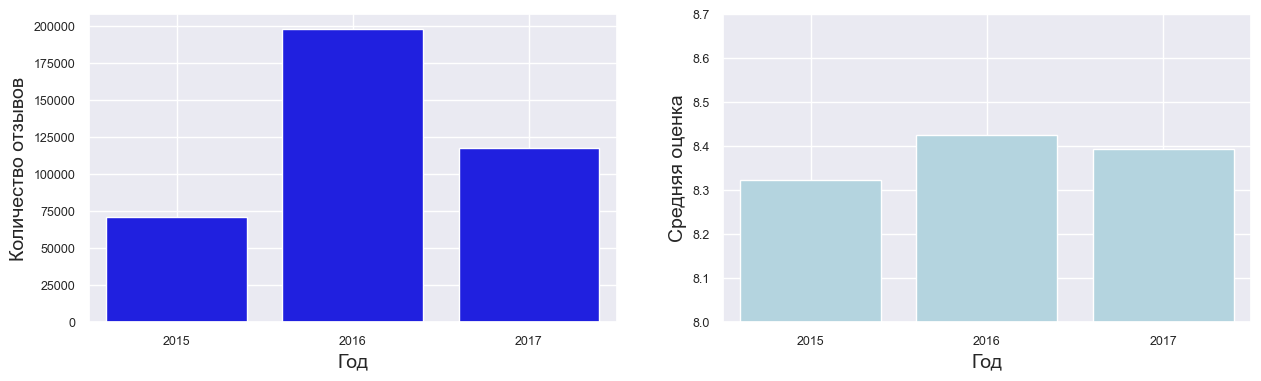

In [56]:
# Визуализируем зависимости количества отзывов и средних оценок от сезона.
quarter = data[data['sample']==1].pivot_table(values='reviewer_score', index='year', aggfunc=['mean','count'])

fig,axes = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(x=quarter.index, y=quarter[('count', 'reviewer_score')], ax=axes[0], color='blue')
axes[0].set_ylabel('Количество отзывов', fontsize = 14)
axes[0].set_xlabel('Год',  fontsize = 14)
axes[0].tick_params(axis='both', which='major', labelsize=9)
axes[0].grid();

sns.barplot(x=quarter.index, y=quarter[('mean', 'reviewer_score')], ax=axes[1], color='lightblue')
axes[1].set_ylabel('Средняя оценка', fontsize = 14);
axes[1].set_xlabel('Год', fontsize = 14)
axes[1].tick_params(axis='both', which='major', labelsize=9)
plt.ylim(8, 8.7)
axes[1].grid();

- В данных виден явный перекос в 2016 году по количеству отзывов
- Признак года также влияет и на среднюю оценку пользователя

In [57]:
# Закодируем признак года:

year_mapping = {2015: 0, 2016: 1, 2017: 2}
data['year'] = data['year'].map(year_mapping)

In [58]:
# Удалим обработанный признак.
data.drop(['review_date'], axis=1, inplace=True)

In [59]:
# Берем из days_since_review количество дней
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))
correlation = data['days_since_review'].corr(data['reviewer_score'])
print(f'Корреляция между days_since_review и reviewer_score: {correlation:.5f}')


Корреляция между days_since_review и reviewer_score: 0.00023


Поскольку корреляция рейтинга отелей и признака *days_since_review* очень мала и совсем непонятно, для чего этот признак нужен, то следует избавиться от него

In [60]:
# Удалим неинформативный признак
data.drop(['days_since_review'], axis=1, inplace=True)

### 2.3. Количество оценок и отзывов

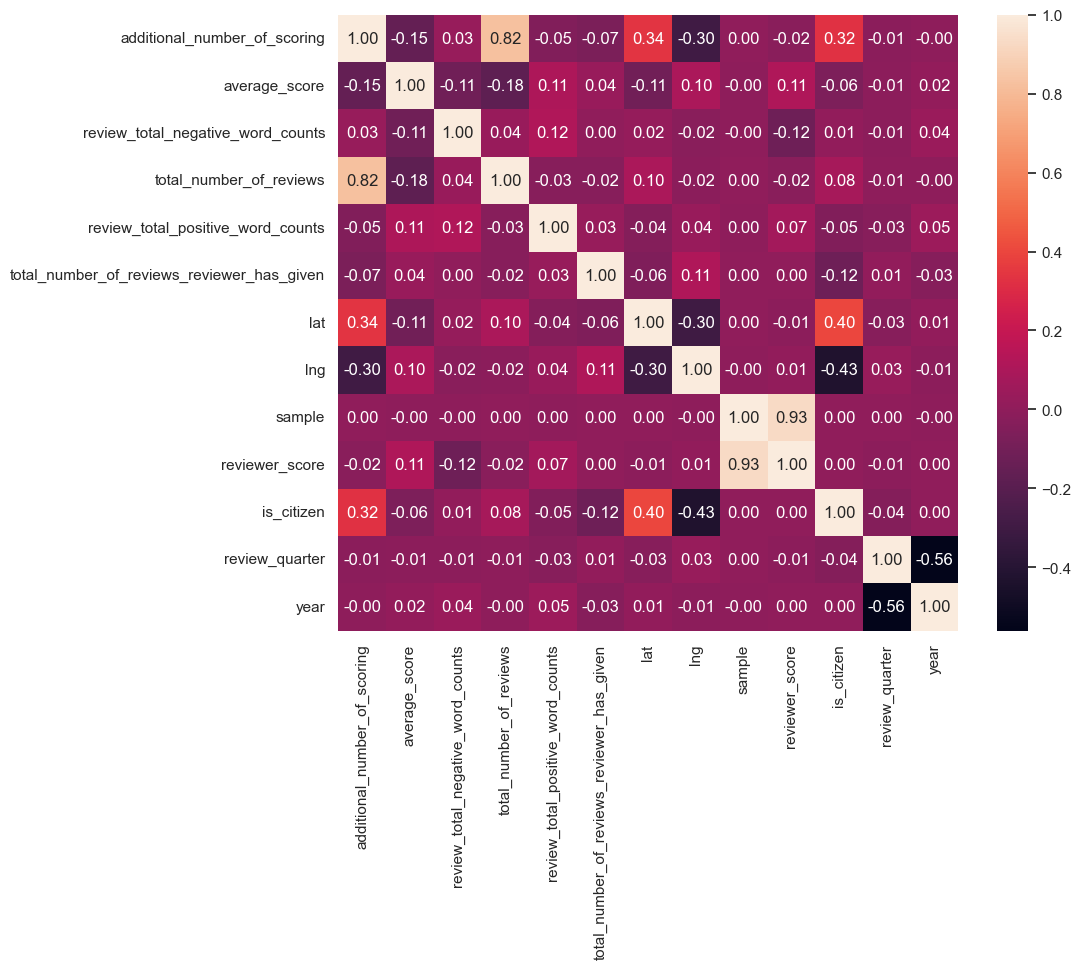

In [61]:
# Посмотрим на промежуточную корреляцию признаков
fig = plt.figure(figsize=(10,8))
numeric_data = data.select_dtypes(include=['number'])
corr_matrix = numeric_data.corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f');

Хотя *additional_number_of_scoring* и *total_number_of_reviews* имеют сильную связь, я решил не удалять ни один из этих признаков, поскольку каждый из них по отдельности имеет ощутимое влияние на построение предсказания рейтинга. В этом можно будет убедиться из распредения в финальной части проекта.

### 2.4. Обработка тегов

In [62]:
# Посчитаем и взглянем на топовые теги.
tags_cntr = Counter(data['tags'].explode())
tags = pd.Series(tags_cntr)
tags.sort_values(ascending=False)[:15]

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']              5101
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     4931
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     4366
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']       3987
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']             3291
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    3099
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    2947
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']                                                  2906
[' Leisure trip ', ' Cou

In [63]:
# Напишем функцию, преобразующую строковые значения в ячейках столбца
# с тегами и возвращающую их в форме списка.
def func_for_tags(string):
    string = string[3:-3]
    result = list(string.split(" ', ' "))
    return result

data['tags'] = data['tags'].apply(func_for_tags)


print(f"Число уникальных тегов: {len(data['tags'].explode().unique())}")

Число уникальных тегов: 2428


In [64]:
# Создадим признак определяющий тип поездки Business или Leisure trip
def trip(line: list) -> int:
    if 'Business trip' in line:
        return 'Командировка'
    if 'Leisure trip' in line:
        return 'Отдых'
    else:
        return 'Отсутствует'

data['trip']=data['tags'].apply(trip)


# Создадим признак определяющий состав заселяющихся в номер.
def comp_checker(line: list) -> int:
    if 'Solo traveler' in line:
        return 1
    if 'Couple' in line:
        return 2
    if 'Group' in line or 'Travelers with friends' in line:
        return 3
    if 'Family with young children' in line or 'Family with older children' in line:
        return 4

data['company']=data['tags'].apply(comp_checker)

# Создадим признак - отправил ли рецензент свой отзыв через телефон.
data['submit'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

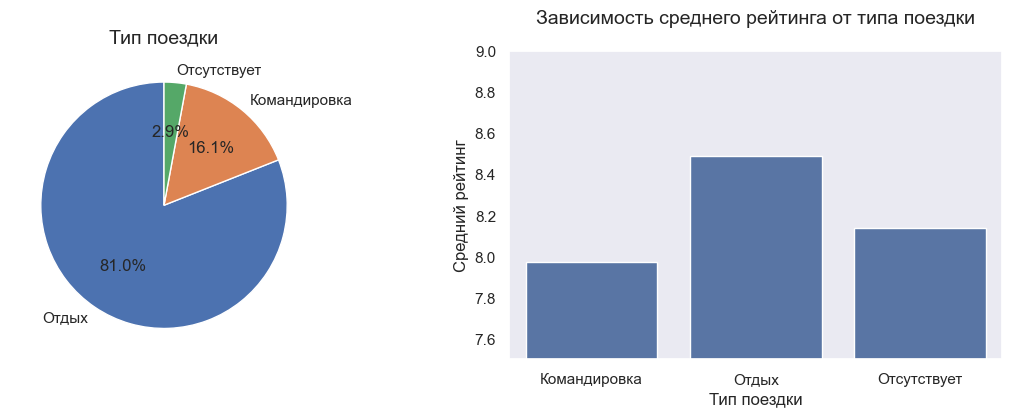

In [65]:
trip_types_pivot = pd.pivot_table(data=data[data['sample']==1],
    index='trip', values='reviewer_score', aggfunc=['mean'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

trip_types_count = data['trip'].value_counts()
ax1.pie(trip_types_count, labels=['Отдых', 'Командировка','Отсутствует'], autopct='%1.1f%%', startangle=90)
ax1.set_title('Тип поездки', fontsize=14)

sns.barplot(x=trip_types_pivot.index, y=trip_types_pivot[('mean', 'reviewer_score')], ax=ax2)
ax2.set_title('Зависимость среднего рейтинга от типа поездки',  fontsize=14,pad=20)
ax2.set_ylabel('Средний рейтинг', fontsize=12)
ax2.set_xlabel('Тип поездки', fontsize=12)
plt.ylim(7.5, 9);

Наблюдается зависимость между типом поездки и рейтингом отеля :
- Преобладающая цель поездки-отдых (81%).
- Люди, приехавшие отдохнуть, в среднем ставят оценку выше, чем те, кто в командировке.

In [66]:
# Сделаем признак количество ночей:

import re

def extract_count_night(string):
    regex = r'Stayed (\d+) night[s]?'
    string = str(string)
    result = re.search(regex, string)
    if result is None:
        return 0
    else:
        return int(result.group(1))

data['night'] = data['tags'].map(extract_count_night)
data['night'].value_counts().head()

night
1    193568
2    133850
3     95761
4     47777
5     20826
Name: count, dtype: int64

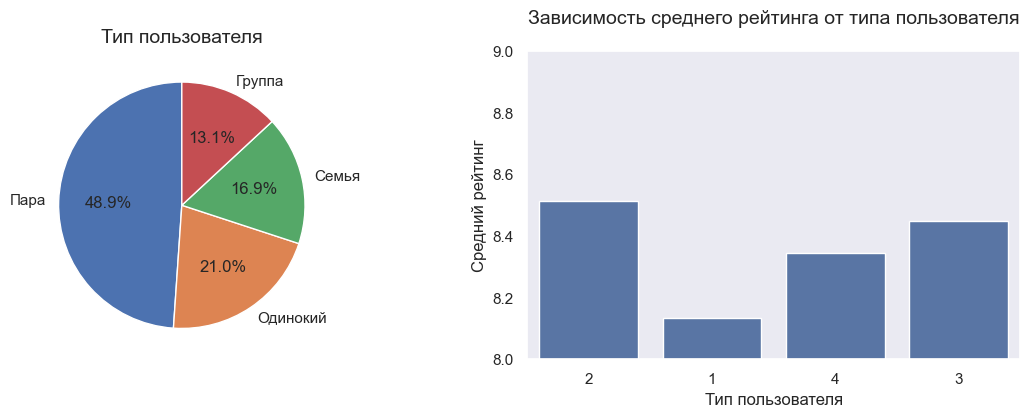

In [67]:
comp_type_pivot = pd.pivot_table(data=data[data['sample']==1],
    index='company', values='reviewer_score', aggfunc=['mean'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

com_types_count = data['company'].value_counts()
ax1.pie(com_types_count, labels=['Пара', 'Одинокий', 'Семья', 'Группа'], autopct='%1.1f%%', startangle=90)
ax1.set_title('Тип пользователя', fontsize=14)

sns.barplot(x=comp_type_pivot.index, y=comp_type_pivot[('mean', 'reviewer_score')], ax=ax2, order=[2,1,4,3])
ax2.set_title('Зависимость среднего рейтинга от типа пользователя',  fontsize=14, pad=20)
ax2.set_ylabel('Средний рейтинг', fontsize=12)
ax2.set_xlabel('Тип пользователя', fontsize=12)
plt.ylim(8, 9);

Наблюдается явное влияние окружения пользователя на оценку, которую он выставляет, а именно:
- Половина пользователей предпочитает отдыхать вдвоем и ставит наибольший рейтинг.
- Высокий балл ставят люди , отдыхающие в группе.
- Одиноким людям обычно все не нравятся, и они ставят низкий балл.

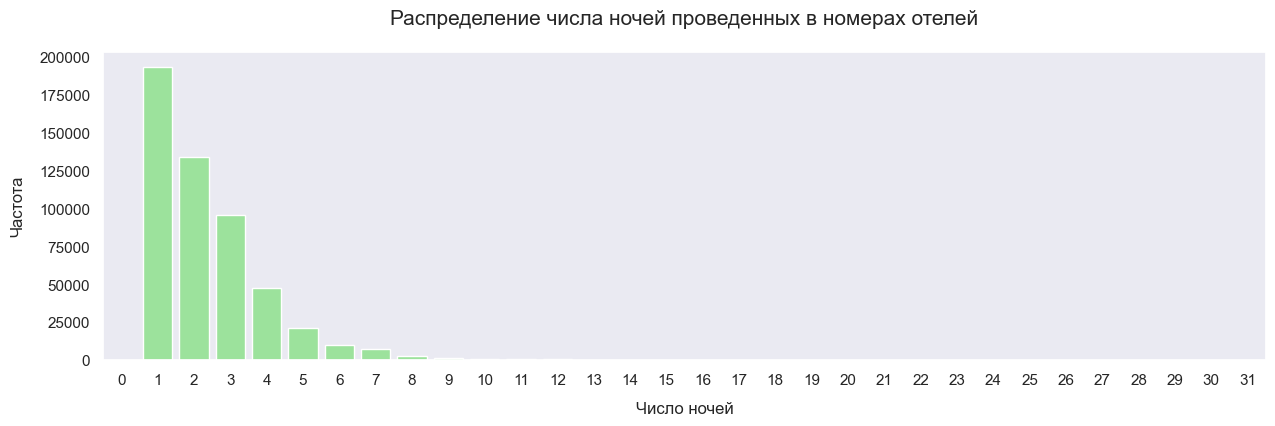

In [68]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.countplot(x=data['night'], color='lightgreen')
ax.set_title('Распределение числа ночей проведенных в номерах отелей',  size=15,pad=20)
ax.set_ylabel('Частота', fontsize = 12, labelpad=10)
ax.set_xlabel('Число ночей', fontsize = 12,labelpad=10);

- Наблюдается равномерное падение числа ночей проведенных в отеле.
- Большинство отелей рассматривается с целью переночевать на одну ночь, а не отдохнуть на несколько дней.

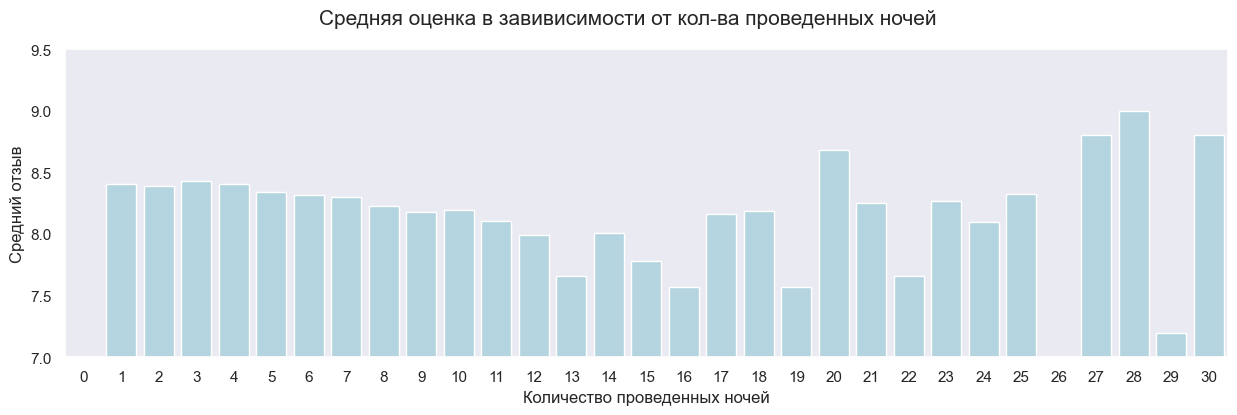

In [69]:
pivot_nights = pd.pivot_table(data=data[data['sample']==1],
    index='night', values='reviewer_score', aggfunc=['mean'])

fig1, ax1 = plt.subplots(figsize=(15, 4))
plt.suptitle('Средняя оценка в завивисимости от кол-ва проведенных ночей', size=15)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('mean', 'reviewer_score')], color='lightblue')
plt.xlabel('Количество проведенных ночей', fontsize = 12)
plt.ylabel('Средний отзыв', fontsize = 12)
plt.ylim(7, 9.5);

Явной зависимости средней оценки в зависимости от количества дней - нет. Но после 13го дня отличия налицо, есть вероятность, что данный признак повлияет на улучшение предсказания.

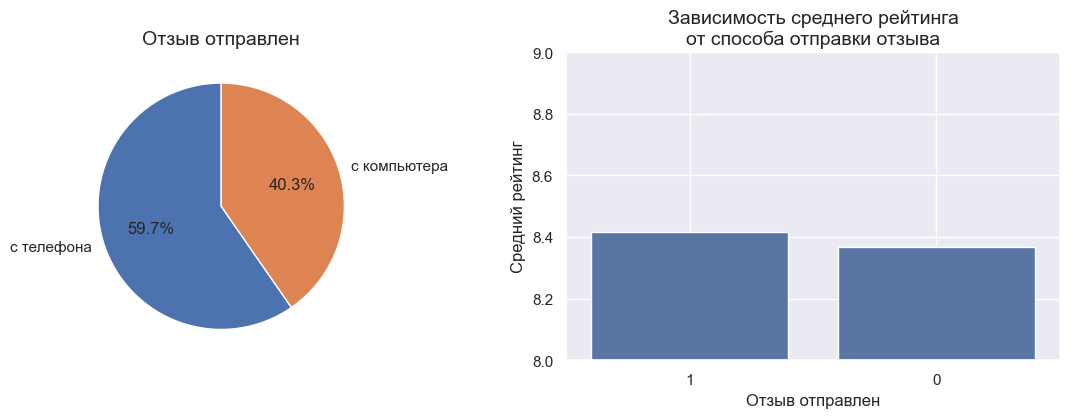

In [70]:
smd_from_mob_pivot = pd.pivot_table(data=data[data['sample']==1],
    index='submit', values='reviewer_score', aggfunc=['mean'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

smd_type = data['submit'].value_counts()
ax1.pie(smd_type, labels=['с телефона', 'с компьютера'], autopct='%1.1f%%', startangle=90)
ax1.set_title('Отзыв отправлен', fontsize=14)

sns.barplot(x=smd_from_mob_pivot.index, y=smd_from_mob_pivot[('mean', 'reviewer_score')], ax=ax2, order=[1, 0])
ax2.set_title('Зависимость среднего рейтинга\nот способа отправки отзыва',  fontsize=14)
ax2.set_ylabel('Средний рейтинг', fontsize=12)
ax2.set_xlabel('Отзыв отправлен', fontsize=12)
ax2.grid()
plt.ylim(8, 9);

- Средний рейтинг у пользователей, которые отправили отзыв с телефона, несущественно выше.

In [71]:
# Удалим обработанный признак.
data.drop(['tags'], axis=1, inplace=True)

In [72]:
# Закодируем trip,company
data = pd.get_dummies(data, columns=['trip','company'])

# Удалим лишние признаки
#data.drop(['submit'], axis=1, inplace=True)


In [73]:
# Удалим неинформативный признак
data.drop(['trip_Отсутствует'], axis=1, inplace=True)

### 2.5. Обработка отзывов

In [74]:
data['negative_review'].value_counts()

negative_review
No Negative                                                                                                                                                                                                             127816
 Nothing                                                                                                                                                                                                                 14291
 Nothing                                                                                                                                                                                                                  4234
 nothing                                                                                                                                                                                                                  2223
 N A                                                                                        

In [75]:
# Создадим признак определяющий есть ли негативный отзыв

def negative_normalize(text):

    negative_variants = [
        '', 'n a', 'na', 'none', 'nada', ' ', 'loved everything',
        'nil', 'can t think of anything', 'everything was perfect',
        'everything was great', 'all good', 'leaving', 'see above',
        'non', 'everything was good', 'i liked everything', 'we liked everything',
        'all was good', 'liked everything', 'as above', 'everything was fine',
        'liked it all', 'there wasn t anything we didn t like', 'all great'
    ]

    text_clean = text.strip().lower()

    # Убираем лишние пробелы внутри строки

    text_clean = ' '.join(text_clean.split())
    text_set = set(text_clean.split())

    if text_clean in negative_variants or text_set.intersection(['nothing', 'no', 'not', 'good', 'ok']):
        return 0 # 0 - негативный отзыв отсутствует
    else:
        return 1 # 1 - значит отзыв действительно негативный

data['negative_binary'] = data['negative_review'].map(negative_normalize)
data['negative_binary'].value_counts()

negative_binary
0    310583
1    204848
Name: count, dtype: int64

In [76]:
data['negative_binary'].value_counts()

negative_binary
0    310583
1    204848
Name: count, dtype: int64

In [77]:
data['positive_review'].value_counts()

positive_review
No Positive                                                                                                                                                35924
 Location                                                                                                                                                   9213
 Everything                                                                                                                                                 2284
 location                                                                                                                                                   1674
 Nothing                                                                                                                                                    1242
                                                                                                                                                           ...  
 Lots places to ea

In [78]:
# Создадим признак определяющий позитивный отзыв

def pozitive_normalize(text):

    text_clean = text.strip().lower()

    # Убираем лишние пробелы внутри строки
    text_clean = ' '.join(text_clean.split())
    text_set = set(text_clean.split())

    if text_set.intersection(['nothing', 'no', 'not', 'bad', 'upset', 'awful']):
        return 0 # В позитивном отзыве либо пусто, либо негативные слова
    else:
        return 1 # Отзыв дествительно позитивный

data['positive_binary'] = data['positive_review'].map(pozitive_normalize)
data['positive_binary'].value_counts()

positive_binary
1    445404
0     70027
Name: count, dtype: int64

In [79]:
data['positive_binary'].value_counts()

positive_binary
1    445404
0     70027
Name: count, dtype: int64

In [80]:
# Удалим лишние признаки
data.drop(['positive_review','negative_review'], axis=1, inplace=True)

### 2.6 Наименование отеля

In [81]:
data['hotel_name'].value_counts()

hotel_name
Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Hotel Daniel Paris                                     12
Boundary Rooms Suites                                  12
Hotel Wagner                                           10
Mercure Paris Porte d Orleans                          10
Hotel Gallitzinberg                                     8
Name: count, Length: 1492, dtype: int64

In [82]:
# Создадим признак определяющий позитивный отзыв
def hotel_name(args):
    if 'Britannia International Hotel Canary Wharf' in args or 'Strand Palace Hotel' in args or 'Park Plaza Westminster Bridge London' in args :
        return 1
    if 'Copthorne Tara Hotel London Kensington' in args or 'DoubleTree by Hilton Hotel London Tower of London' in args:
        return 2
    else:
        return 0

data['name']=data['hotel_name'].apply(hotel_name)

In [83]:
data['name'].value_counts()

name
0    495427
1     13214
2      6790
Name: count, dtype: int64

In [84]:
# Закодируем name
data = pd.get_dummies(data, columns=['name'])

In [85]:
# Удалим лишние признаки
data.drop(['name_0'], axis=1, inplace=True)

In [86]:
# Удалим лишние признаки
data.drop(['hotel_name'], axis=1, inplace=True)

## 3. Корреляция признаков

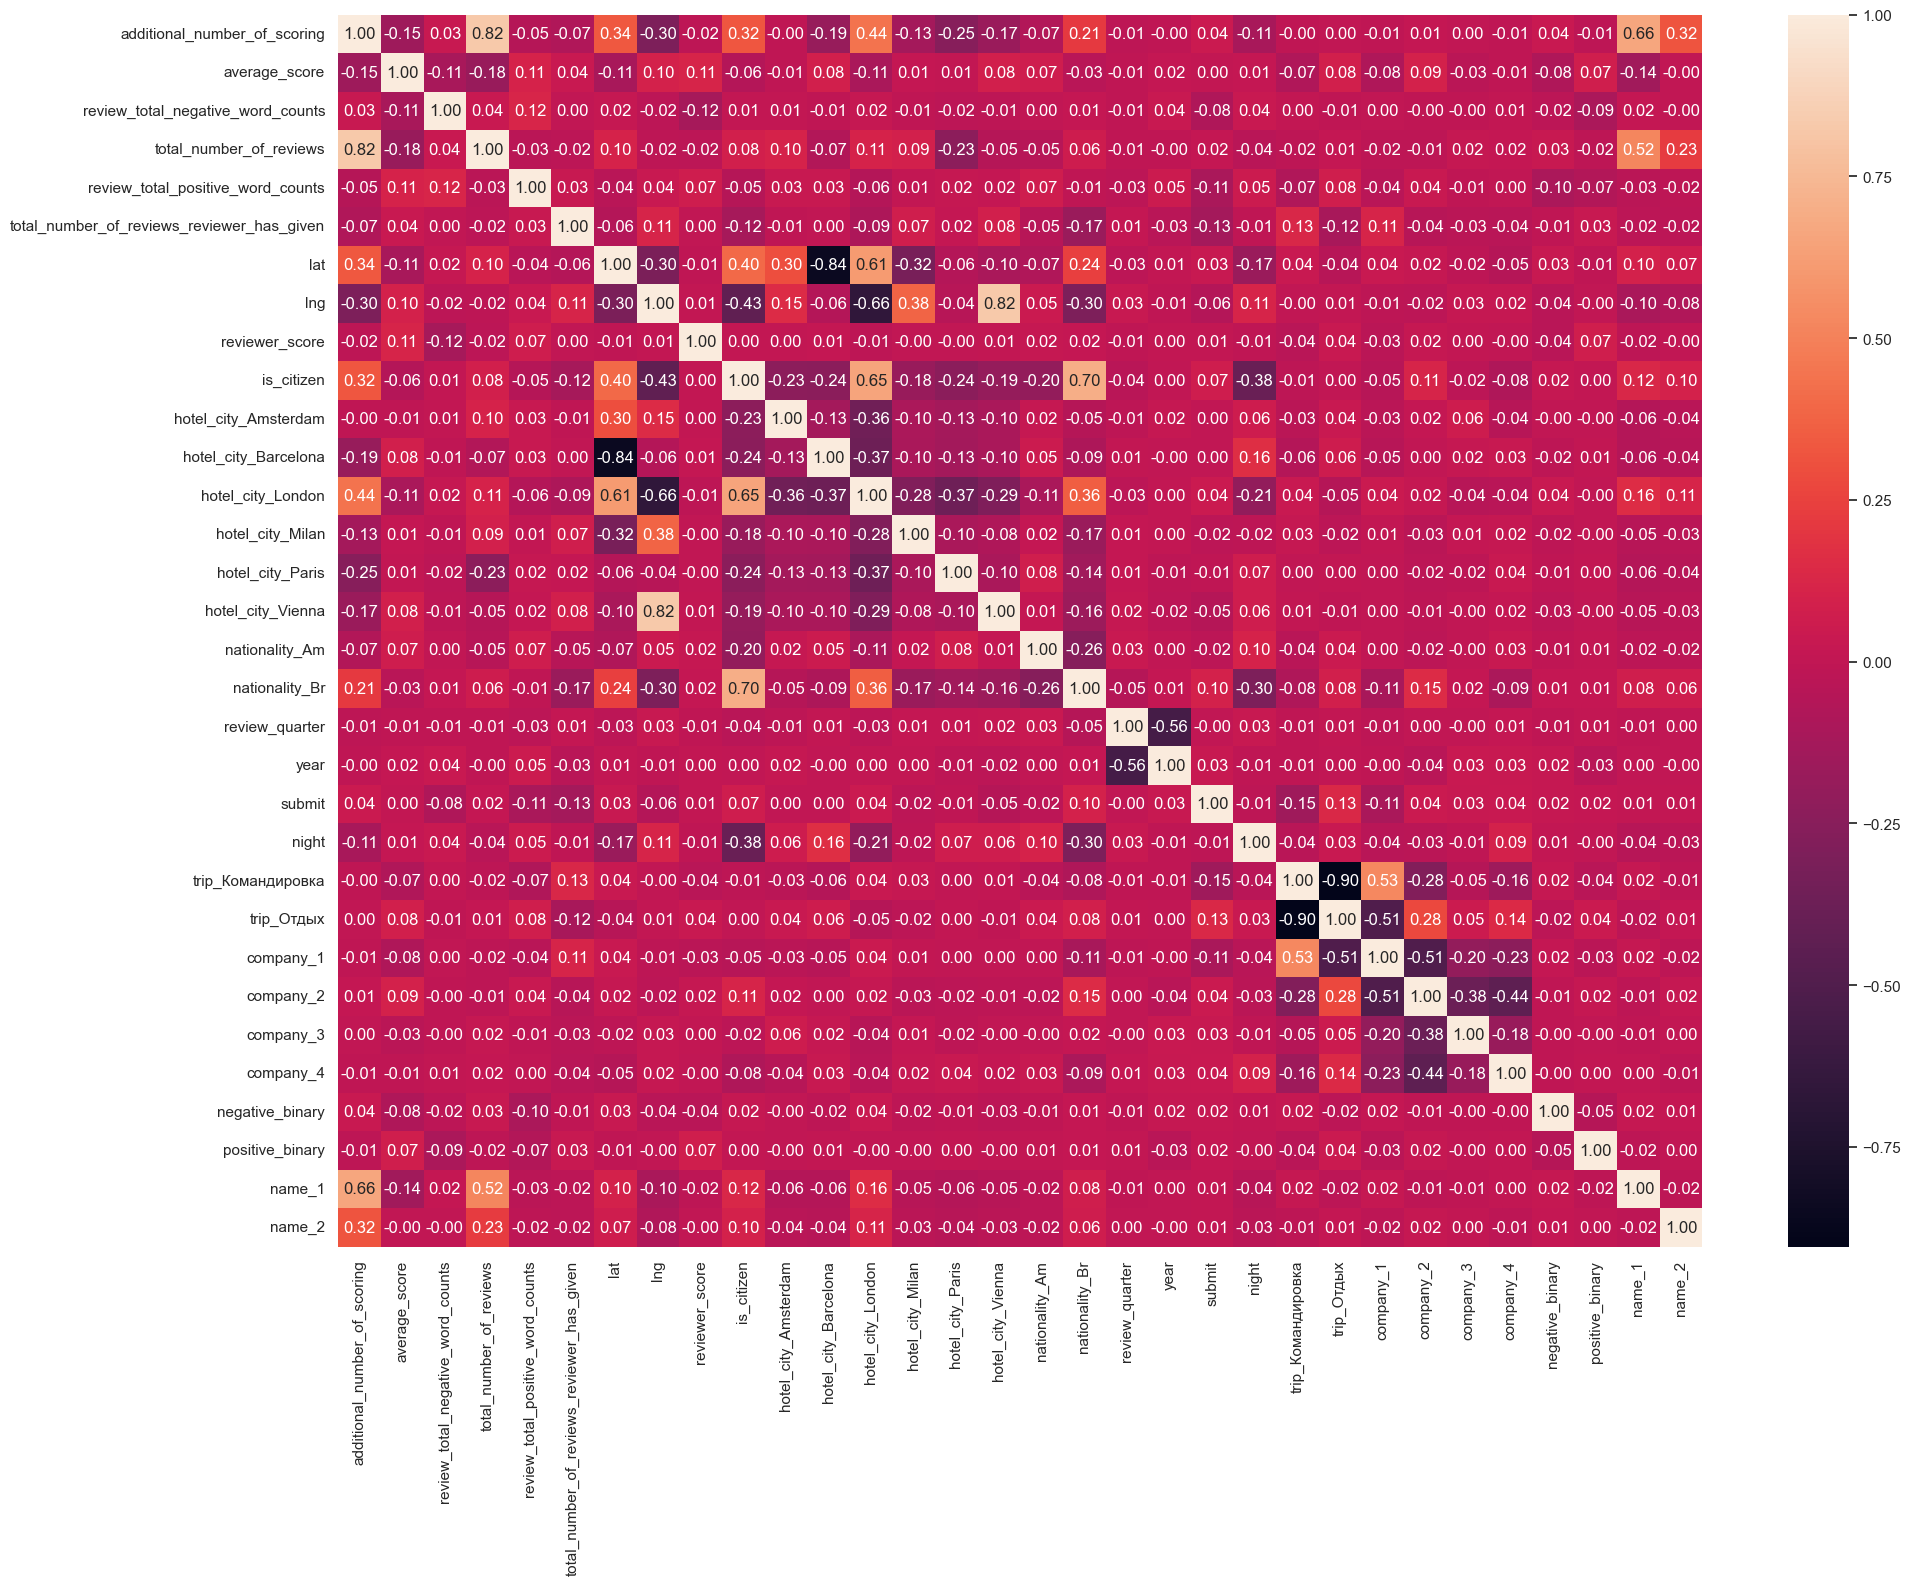

In [87]:
plt.rcParams['figure.figsize'] = (22,16)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True, fmt='.2f');

In [88]:
# Удалим признаки с сильной корреляционной связью:
data.drop(['hotel_city_Barcelona', 'trip_Командировка'], axis=1, inplace=True)

## 4. Нормализация данных

Проверим числовые признаки на нормальность. Поскольку тест Шапиро-Уилка предназначен для небольших и средних выборок (до 5000 наблюдени), то воспользуемся тестом Андерсона-Дарлинга

In [89]:
import scipy.stats as stats

# Проверка нормальности через тест Андерсона-Дарлинга
def anderson_darling_test(data, alpha=0.05):

    result = stats.anderson(data, dist='norm')
    print(f"Anderson-Darling: A^2 = {result.statistic:.3f}")

    # Сравниваем с критическими значениями для выбранного уровня значимости
    critical_values = result.critical_values
    significance_levels = result.significance_level

    # Находим индекс для заданного alpha (обычно 5% = 0.05)
    idx = np.where(significance_levels == alpha*100)[0][0]

    if result.statistic > critical_values[idx]:
        print(f"Распределение не нормальное (AD-test на уровне {alpha})")
    else:
        print(f"Распределение нормальное (AD-test на уровне {alpha})")

In [90]:
# В переменную digit_cols запишем стоблцы, которые мы будет проверять на нормальность
digit_cols = list(data.nunique()[data.nunique() > 4].index)
for col in digit_cols:
    print(col,':')
    anderson_darling_test(data[col])
    print('-'*40)

additional_number_of_scoring :
Anderson-Darling: A^2 = 31720.810
Распределение не нормальное (AD-test на уровне 0.05)
----------------------------------------
average_score :
Anderson-Darling: A^2 = 2366.414
Распределение не нормальное (AD-test на уровне 0.05)
----------------------------------------
review_total_negative_word_counts :
Anderson-Darling: A^2 = 50578.558
Распределение не нормальное (AD-test на уровне 0.05)
----------------------------------------
total_number_of_reviews :
Anderson-Darling: A^2 = 22226.330
Распределение не нормальное (AD-test на уровне 0.05)
----------------------------------------
review_total_positive_word_counts :
Anderson-Darling: A^2 = 39818.414
Распределение не нормальное (AD-test на уровне 0.05)
----------------------------------------
total_number_of_reviews_reviewer_has_given :
Anderson-Darling: A^2 = 60609.827
Распределение не нормальное (AD-test на уровне 0.05)
----------------------------------------
lat :
Anderson-Darling: A^2 = 61399.734
Рас

#### Все рассматриваемые признаки не распределены нормально, поэтому займемся их нормализацией. Поскольку мы не удаляли выбросы, оптимально будет использовать *RobustScaler*

In [91]:
from sklearn.preprocessing import RobustScaler

if 'reviewer_score' in digit_cols:
    digit_cols.remove('reviewer_score')

data[digit_cols] = data[digit_cols].astype(float)
data[digit_cols] = RobustScaler().fit_transform(data[digit_cols].values)


## 5. Разделение выборки на *x* и *y*, обучение модели

In [92]:
# убираем признаки которые еще не успели обработать,
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [93]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

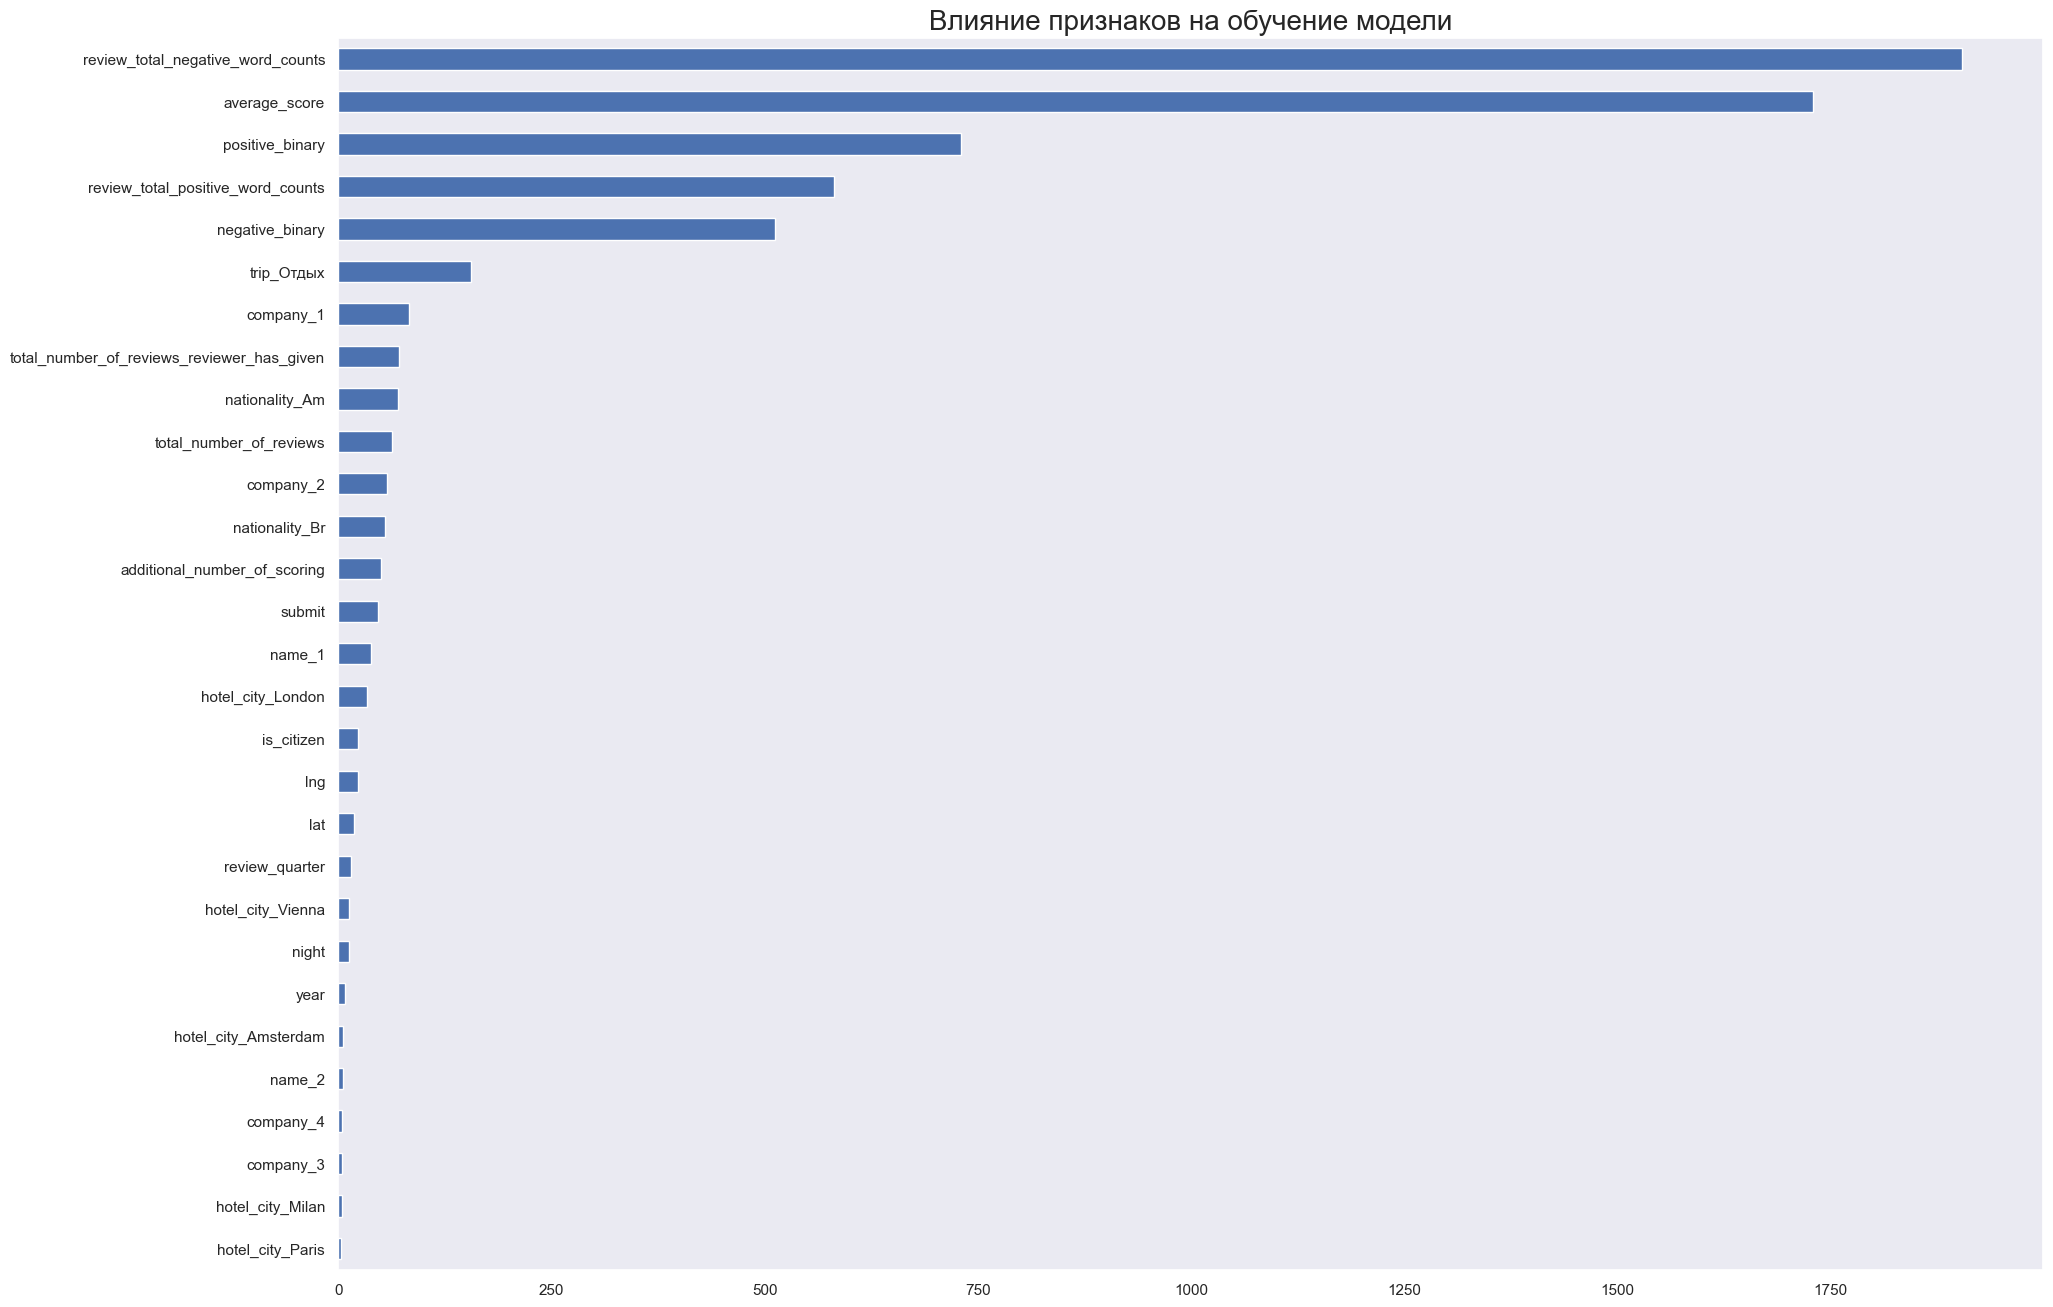

In [94]:
from sklearn.feature_selection import f_classif # anova

columns=X.columns

imp_num = pd.Series(f_classif(X, y)[0], index = columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh').set_title('Влияние признаков на обучение модели', size=20);

In [95]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [96]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 30), (386496, 30), (386496, 29), (309196, 29), (77300, 29))

In [97]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [98]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [99]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished


In [100]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9176648653360435


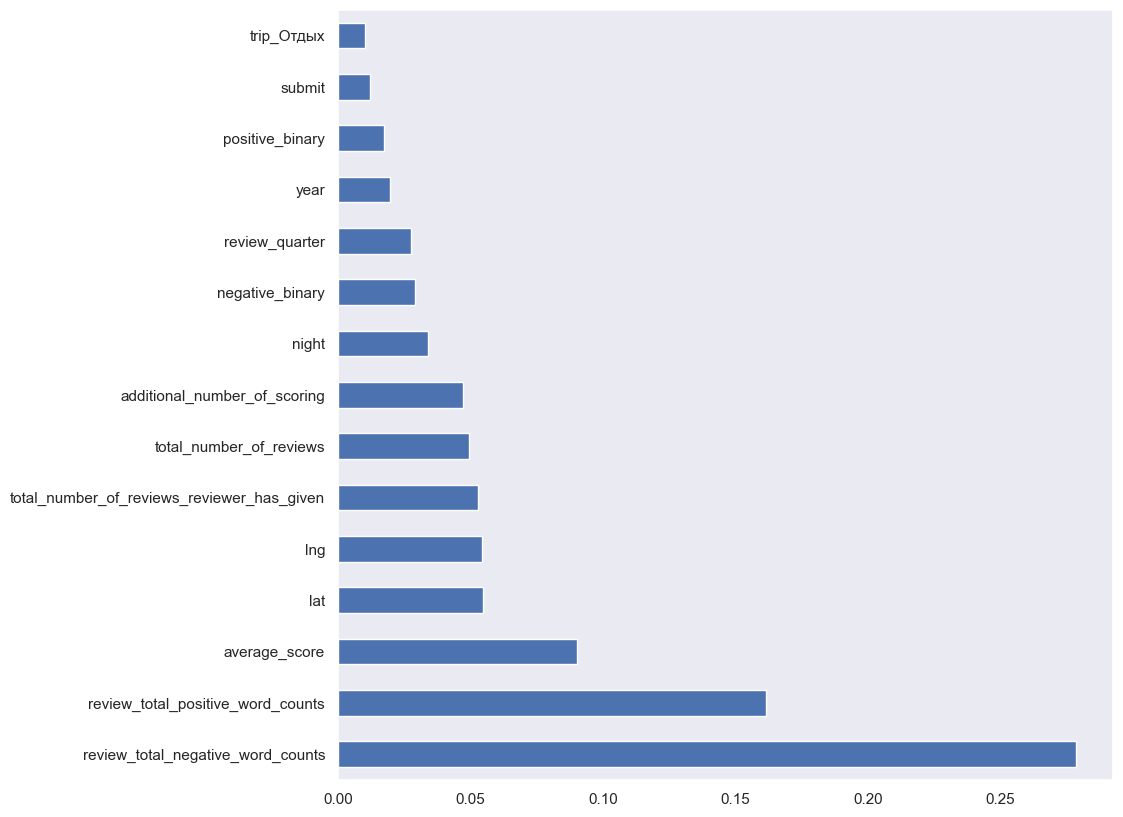

In [101]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [102]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,is_citizen,...,night,trip_Отдых,company_1,company_2,company_3,company_4,negative_binary,positive_binary,name_1,name_2
112414,-0.183299,1.000000,0.333333,-0.391586,1.117647,-0.285714,0.002334,-0.033508,0.0,1,...,-0.5,False,True,False,False,False,0,0,False,False
51806,1.350305,-0.142857,0.476190,0.540049,-0.647059,-0.285714,0.017897,-0.061107,0.0,1,...,-0.5,True,False,True,False,False,0,0,False,False
18451,-0.405295,-1.142857,-0.333333,-0.332120,-0.235294,-0.142857,-0.805357,0.458060,0.0,0,...,1.5,True,False,False,False,True,0,0,False,False
56824,-0.633401,-0.857143,1.619048,-0.747168,-0.647059,0.000000,-3.063198,0.433513,0.0,0,...,1.0,True,False,False,False,True,1,0,False,False
99804,0.378819,0.428571,-0.238095,0.141990,1.647059,-0.285714,-0.001849,-0.040602,0.0,0,...,0.5,True,False,False,False,True,0,0,False,False
86190,0.659878,0.142857,-0.333333,0.980987,-0.529412,0.571429,-3.066523,0.433704,0.0,0,...,0.5,True,True,False,False,False,1,1,False,False
41363,-0.517312,0.142857,-0.428571,-0.632686,0.176471,-0.142857,-0.795489,0.459274,0.0,0,...,1.0,True,True,False,False,False,0,1,False,False
100871,-0.441955,0.285714,-0.190476,-0.334547,1.588235,0.571429,-0.999208,3.281644,0.0,0,...,1.0,True,False,True,False,False,0,1,False,False
8326,-0.325866,1.000000,1.333333,-0.495550,4.588235,-0.142857,0.264262,0.975706,0.0,0,...,0.5,True,False,True,False,False,0,1,False,False
111112,-0.645621,1.285714,-0.428571,-0.776699,-0.235294,0.571429,-0.801301,0.465060,0.0,0,...,-0.5,True,False,True,False,False,0,1,False,False


In [103]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [104]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.2s finished


In [105]:
predict_submission

array([8.791, 6.772, 8.119, ..., 7.908, 9.551, 6.964])

In [106]:
list(sample_submission)

['reviewer_score', 'id']

In [107]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.791,488440
1,6.772,274649
2,8.119,374688
3,9.501,404352
4,9.461,451596
5,8.722,302161
6,7.956,317079
7,6.509,13963
8,8.715,159785
9,8.311,195089
